In this notebook we will attempt to perform automatic binding site identification from existing footprint.

In [1]:
## processing
import numpy as np
import pandas as pd
from itertools import compress

## custom package
import tregseq

## visualization
import matplotlib.pyplot as plt

## Computing information footprint from phenotype matrix generated by MCMC

Let's first take a look at the footprint. This is from Tom's control experiment where he generated information footprint for five gold standard genes to compare the genome integrated system and the plasmid system as well as the reads when the entire mRNA is amplified versus when when we only amplify the barcode region.

In [2]:
df = pd.read_csv('../data/footprints/p88_rspAp_mcmc_mpathic_2.csv')
df.head()

,Unnamed: 0,pos,val_A,val_C,val_G,val_T
0,0,0,-0.018782,-0.023612,0.016329,0.026066
1,1,1,-0.018611,0.020023,-0.009416,0.008005
2,2,2,0.014759,-0.015312,-0.002662,0.003215
3,3,3,0.016626,0.003532,-0.049124,0.028966
4,4,4,-0.008693,0.046806,-0.034645,-0.003467


In [3]:
def phenotype_to_prob(row):
    # compute the probability distribution
    prob = []
    for col_name in [('val_' + x) for x in ['A', 'C', 'G', 'T']]:
        prob.append(np.exp(row[col_name]))
    prob = np.asarray(prob)
    prob = prob / np.sum(prob)
    return prob

In [4]:
def get_rel_entr(row):
    prob = phenotype_to_prob(row)

    rel_entr = 0
    for i in range(4):
        rel_entr += prob[i] * np.log2(prob[i] / 0.25)
    
    return rel_entr

In [5]:
df['rel_entr'] = df.apply(lambda row: get_rel_entr(row), axis=1)
df.head()

,Unnamed: 0,pos,val_A,val_C,val_G,val_T,rel_entr
0,0,0,-0.018782,-0.023612,0.016329,0.026066,0.000335
1,1,1,-0.018611,0.020023,-0.009416,0.008005,0.000162
2,2,2,0.014759,-0.015312,-0.002662,0.003215,0.000085
3,3,3,0.016626,0.003532,-0.049124,0.028966,0.000628
4,4,4,-0.008693,0.046806,-0.034645,-0.003467,0.000634


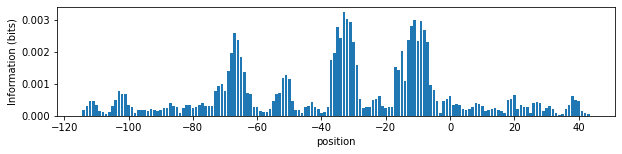

In [6]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
#exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
#shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(df['rel_entr'], windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None) #, color=shiftcolors
plt.show()


Through visual inspection, we will say that the binding sites would be at -75 to -60, -40 to -20, and -20 to -5. We will determine these binding sites algorithmically and see if it matches with our expectations.

## First try at binding site identification

In [7]:
heights = df['rel_entr']
avg_height = np.mean(heights)

Let's take a look at what the average looks like on the footprint.

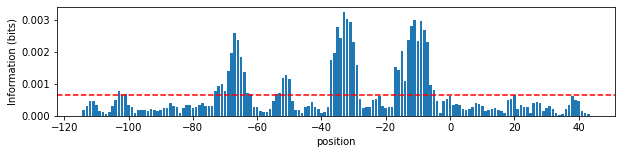

In [8]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
#exshift_list = tregseq.footprint.get_expression_shift(mut_list, mu_data.values, wtseq, smoothed=True, windowsize=windowsize)
#shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(df['rel_entr'], windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None) #, color=shiftcolors
ax.axhline(avg_height, color='red', linestyle='--')
plt.show()

By eye it looks like it's above the noise level. Now let's do our sliding window calculation.

In [9]:
windowsize = 10
stepsize = 5
position = 0
window_ratio = []
positions = []
while position <= (len(heights) - windowsize):
    window = heights[position:(position + windowsize)]
    window_avg = np.mean(window)
    window_ratio.append(window_avg / avg_height)
    positions.append((position - 115, position + 10 - 115))
    position += stepsize

In [10]:
## calculating the number of windows in which the signal is at least twice the level of noise.

np.sum(np.asarray(window_ratio) >= 2)

6

Now let's map the windows with high signal to the positions

In [11]:
peak_windows = list(compress(positions, np.asarray(window_ratio) >= 2))
peak_windows

[(-70, -60), (-40, -30), (-35, -25), (-20, -10), (-15, -5), (-10, 0)]

Now we can merge the windows that are overlapping. **It might also be a good idea to merge the windows that are adjacent, but let's first see how merging overlapping windows would work out.**

In [12]:
# I am stealing/adapting this function from hcrpaper

def combine_regions(regions):

    regions = sorted(regions)
    # sorting is necessary: the rest of the function does not work if list is not sorted

    last_combined = regions
    combined_regions = []
    i = 0
    while i < len(regions):
        start = regions[i][0]
        tmp_end = regions[i][1]
        tmp_index = i
        for j in range(i+1, len(regions)):
            if regions[j][0] <= tmp_end:
                tmp_end = regions[j][1]
                tmp_index = j
        combined_regions.append((start, tmp_end))
        i = tmp_index + 1

    return combined_regions

In [13]:
binding_sites = combine_regions(peak_windows)
binding_sites

[(-70, -60), (-40, -25), (-20, 0)]

Okay, these more or less match with the binding sites that we expected to have. Let's plot this on the information footprint as well.

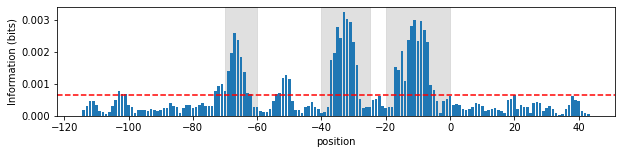

In [17]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregseq.utils.smoothing(df['rel_entr'], windowsize=windowsize)
for binding_site in binding_sites:
    ax.axvspan(binding_site[0], binding_site[1], alpha=0.7, color='lightgray')
ax.bar(x, footprint_smoothed, edgecolor=None) #, color=shiftcolors
ax.axhline(avg_height, color='red', linestyle='--')
plt.show()

Okay it definitely seems to roughly match the binding sites. Let's try a few more combinations of window size and step size to see if it generates better boundaries.

## Choosing optimal window size and step size

Presumably the window size would correspond to the minimum length of promoter required for DNA-protein binding.

In [18]:
def find_binding_sites(df, windowsize, stepsize,
                       min_ratio=2):
    heights = df['rel_entr']
    avg_height = np.mean(heights)

    position = 0
    window_ratio = []
    positions = []
    while position <= (len(heights) - windowsize):
        window = heights[position:(position + windowsize)]
        window_avg = np.mean(window)
        window_ratio.append(window_avg / avg_height)
        positions.append((position - 115, position + windowsize - 115))
        position += stepsize

    peak_windows = list(compress(positions, np.asarray(window_ratio) >= min_ratio))
    binding_sites = combine_regions(peak_windows)
    return binding_sites

In [19]:
def plot_info_footprint(footprint, binding_sites, smoothing_winsize=3):
    fig, ax = plt.subplots(figsize=(10,2))
    ax.set_ylabel('Information (bits)')
    ax.set_xlabel('position')

    cut = int((smoothing_winsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    footprint_smoothed = tregseq.utils.smoothing(df['rel_entr'], windowsize=smoothing_winsize)
    for binding_site in binding_sites:
        ax.axvspan(binding_site[0], binding_site[1], alpha=0.7, color='lightgray')
    ax.bar(x, footprint_smoothed, edgecolor=None) #, color=shiftcolors
    ax.axhline(avg_height, color='red', linestyle='--')
    plt.show()
    plt.show()

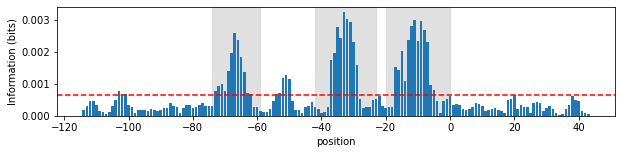

In [20]:
windowsize = 10
stepsize = 1
binding_sites = find_binding_sites(df, windowsize=windowsize, stepsize=stepsize)
plot_info_footprint(df['rel_entr'], binding_sites)

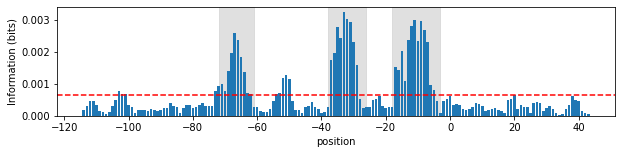

In [21]:
windowsize = 5
stepsize = 1
binding_sites = find_binding_sites(df, windowsize=windowsize, stepsize=stepsize)
plot_info_footprint(df['rel_entr'], binding_sites)

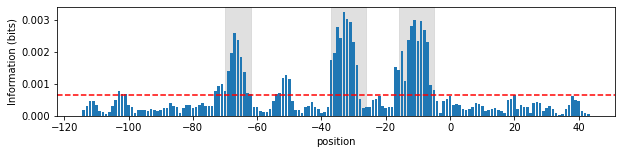

In [22]:
windowsize = 5
stepsize = 3
binding_sites = find_binding_sites(df, windowsize=windowsize, stepsize=stepsize)
plot_info_footprint(df['rel_entr'], binding_sites)

We see that a window size of 5 and a step size of 1 seem to work best for this particular set of information footprint. It remains to be tested whether this can generally apply to all information footprint or if we need to adjust the window size and the step size on a case-by-case basis.

## Testing on other information footprint

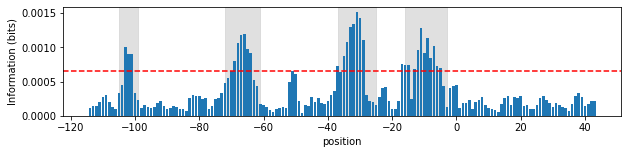

In [23]:
df = pd.read_csv('../data/footprints/g88_rspAp_mcmc_mpathic_2.csv')
df['rel_entr'] = df.apply(lambda row: get_rel_entr(row), axis=1)
windowsize = 5
stepsize = 1
binding_sites = find_binding_sites(df, windowsize=windowsize, stepsize=stepsize)
plot_info_footprint(df['rel_entr'], binding_sites)

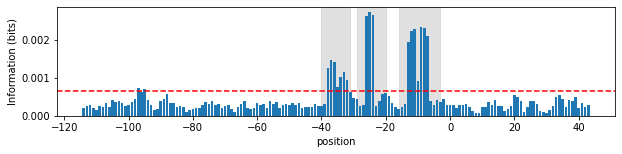

In [24]:
df = pd.read_csv('../data/footprints/p88_xylFp_mcmc_mpathic_2.csv')
df['rel_entr'] = df.apply(lambda row: get_rel_entr(row), axis=1)
windowsize = 5
stepsize = 1
binding_sites = find_binding_sites(df, windowsize=windowsize, stepsize=stepsize)
plot_info_footprint(df['rel_entr'], binding_sites)

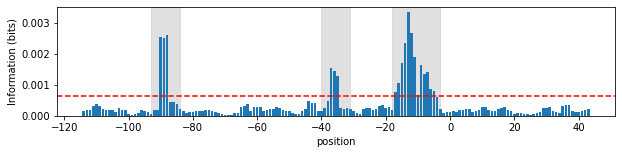

In [25]:
df = pd.read_csv('../data/footprints/p88_znuCp_mcmc_mpathic_2.csv')
df['rel_entr'] = df.apply(lambda row: get_rel_entr(row), axis=1)
windowsize = 5
stepsize = 1
binding_sites = find_binding_sites(df, windowsize=windowsize, stepsize=stepsize)
plot_info_footprint(df['rel_entr'], binding_sites)

## Comparison with expression shift

In [28]:
df_p88 = pd.read_csv('../data/footprints/raw_data/p88_barcodes.csv')
df_p88_rspAp = df_p88[df_p88.name == 'rspAp'][['promoter', 'ct_0', 'ct_1']]
df_p88_rspAp.head()

,promoter,ct_0,ct_1
3,GTTCATCTTTTTTCAACCATTCAAATCGCACATATACGCCTTTTTT...,11,15
14,CTGCATCCTTAGTCAAACATTCACAGCGCAAATCCACGCCTTTGTT...,3,0
15,CTCGATCTTTTGTCAACCATTCACAGCGCGAATATACGCCATTTTT...,41,7
17,CTACATCTTTTGTCAATCATTCACAGCGCAAATATACGACTTTTTT...,6,14
29,ATTCATCTAATGTCAACTATTCACAGCGCAAATATACGCCTTTTTT...,3,0


TO-DO:
- take a look at how the binding sites align with the boundaries provided by expression shift AND if the expression shift boundary can help to better refine the boundary
- try the method on noisier information footprints
- try it on mutual-information-based information footprints
- add step for merging neighboring binding sites (maybe by adding tolerance? or just adding maximum distance between adjacent peaks)
- try different threshold for signal-to-noise ratio
- develop the code into the script
- Make a consolidated figure to show result